# Analyze Base Kit Strength

First, we will analyze just kit strength. 
We will create a model that predicts battle results based
only on the sum of the kit strengths of the two teams.
Besides ignoring player skills, this model will also ignore
synergies between kits on the same team, anti-synergies
between kits on opposite teams, game versions, maps,
and game modes.

In [1]:
import logging

logger = logging.getLogger("analyze_base_kit_strength_notebook")
logging.basicConfig(level=logging.INFO)

## Demo battle record creator
Here is a small battle record creator for refining the model

In [2]:
from battle_record import BattleRecord
from typing import Generator


def some_battle_records() -> Generator[BattleRecord, None, None]:
    from read_battle_records import battle_records_from_zip

    return battle_records_from_zip("2024-04-26.zip")

In [3]:
def mar_apr_battle_records() -> Generator[BattleRecord, None, None]:
    """Records for March 27 - April 26, 2024 inclusive"""
    from read_battle_records import battle_records_from_zip

    return battle_records_from_zip("2024-mar-apr-battles.zip")

## Duplicate kit_only_model code

For the sake of not having to reload the libraries constantly, we will duplicate the code
from the `kit_only_model` function in the `battle_record_analysis` module. This will enable
faster iteration.

In [40]:
import numpy as np
import pytensor.tensor as tt
from battle_record_analysis import (
    all_kits_used,
    all_observed_kit_variables_and_battle_results,
)
import pymc as pm
from typing import Callable, Iterable


def kit_only_model(
    battle_record_creator: Callable[[], Iterable[BattleRecord]]
) -> pm.Model:
    """
    Create a PyMC3 model for the given battle record creator.

    Team strength is determined by the kits used by the team members.
    let A = alpha_strength and B = bravo_strength
    prob_team_alpha_win = exp(A)/(exp(A)+exp(B))
    This can be rewritten as prob_team_alpha_win = 1/(1+exp(B)/exp(A)) = 1/(1+exp(B-A))

    Here is the formula for each battle record:
    kit_strength = pm.Exp("kit_strength", 1, dims=("kits",))
    both_sides_kit_strengths = concatenate(kit_strength, kit_strength)
    The basic formula is prob_team_alpha_win for each battle = exp(
        dot(kit_strengths, observed_kits)
    )
    Kit strength's prior distributed as a normal variable with mean 1

    Args:
        battle_record_creator: A callable that returns an
            iterable of battle records (generally by re-opening the file)

    Returns:
        A PyMC3 model for the given battle record creator.
    """
    kits = sorted(all_kits_used(battle_record_creator()))
    kit_index = {kit: i for i, kit in enumerate(kits)}
    observed_kit_variables, battle_results = (
        all_observed_kit_variables_and_battle_results(
            battle_record_creator(), kit_index
        )
    )
    shuffled_indices = np.random.permutation(battle_results.shape[0])

    logger.info(f"Done reading.")
    logger.info(f"Number of kits: {len(kits)}")
    logger.info(f"Shape of observed_kit_variables: {observed_kit_variables.shape}")
    logger.info(f"Shape of battle_results: {battle_results.shape}")

    coords = {"kits": kits}
    with pm.Model(coords=coords) as model:
        observed_kit_data = pm.Data(
            "observed_kit_data", observed_kit_variables[shuffled_indices]
        )
        battle_results_data = pm.Data(
            "battle_results_data", battle_results[shuffled_indices]
        )

        kit_strength = tt.reshape(
            pm.Normal("kit_strength", mu=1, sigma=0, dims="kits"), (1, -1)
        )
        both_sides_kit_strengths = pm.math.concatenate(
            [kit_strength, kit_strength], axis=1
        )
        logger.info(
            f"Shape of both_sides_kit_strengths: {both_sides_kit_strengths.shape.eval()}"
        )
        all_matches_kit_strengths = tt.repeat(
            both_sides_kit_strengths,
            observed_kit_data.shape[0],
            axis=0,
        )
        logger.info(
            f"Shape of all_matches_kit_strengths: {all_matches_kit_strengths.shape.eval()}"
        )

        kit_contributions = all_matches_kit_strengths * observed_kit_data
        team_beta_advantage = tt.exp(
            tt.reshape(tt.sum(kit_contributions, axis=1), (-1, 1))
        )
        logger.info(f"Shape of team_beta_advantage: {team_beta_advantage.shape.eval()}")

        prob_team_alpha_win = 1 / (1 + team_beta_advantage)
        pm.Bernoulli(
            "battle_results", prob_team_alpha_win, observed=battle_results_data
        )

    return model

In [41]:
from pymc import HamiltonianMC

with kit_only_model(some_battle_records) as small_model:
    kit_only_trace = pm.sample(1000, tune=1000, progressbar=True, step=HamiltonianMC())

Reading battles: 100%|██████████| 9.98M/9.98M [00:00<00:00, 17.1MBytes/s, 2024-04-26.csv]
Processing battle records: 0it [00:00, ?it/s]
Reading battles:   0%|          | 0.00/9.98M [00:00<?, ?Bytes/s]
Processing battle records: 5588it [00:00, 11184.52it/s]?Bytes/s, 2024-04-26.csv]
Reading battles: 100%|██████████| 9.98M/9.98M [00:00<00:00, 18.2MBytes/s, 2024-04-26.csv]
Processing battle records: 6095it [00:00, 11060.08it/s]
INFO:analyze_base_kit_strength_notebook:Done reading.
INFO:analyze_base_kit_strength_notebook:Number of kits: 120
INFO:analyze_base_kit_strength_notebook:Shape of observed_kit_variables: (6095, 240)
INFO:analyze_base_kit_strength_notebook:Shape of battle_results: (6095, 1)
INFO:analyze_base_kit_strength_notebook:Shape of both_sides_kit_strengths: [  1 240]
INFO:analyze_base_kit_strength_notebook:Shape of all_matches_kit_strengths: [6095  240]
INFO:analyze_base_kit_strength_notebook:Shape of team_beta_advantage: [6095    1]
D:\Programs\Miniforge3\envs\Splatoon3Rank\L

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'kit_strength': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])}

Logp initial evaluation results:
{'kit_strength': -inf, 'battle_results': -inf}
You can call `model.debug()` for more details.

In [28]:
import pickle

pickle.dump(kit_only_trace, open("2024-04-26.kit_only_trace.pkl", "wb"))

In [29]:
import arviz as az

az.summary(kit_only_trace, var_names=["kit_strength"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kit_strength[52gal],-0.209,5.850,-6.260,9.605,2.911,2.229,4.0,12.0,3.39
kit_strength[52gal_deco],-0.162,5.850,-6.270,9.637,2.911,2.229,4.0,12.0,3.34
kit_strength[96gal],-0.484,5.856,-6.658,9.351,2.913,2.230,5.0,14.0,3.15
kit_strength[96gal_deco],-0.422,5.849,-6.554,9.358,2.910,2.228,4.0,12.0,3.29
kit_strength[bamboo14mk1],-0.410,5.856,-6.616,9.367,2.913,2.230,4.0,12.0,3.21
...,...,...,...,...,...,...,...,...,...
kit_strength[variableroller],-0.340,5.849,-6.513,9.374,2.911,2.228,4.0,11.0,3.33
kit_strength[variableroller_foil],-0.261,5.857,-6.450,9.512,2.914,2.231,4.0,12.0,3.24
kit_strength[wakaba],-0.276,5.849,-6.364,9.497,2.911,2.228,4.0,12.0,3.38
kit_strength[wideroller],-0.677,5.851,-6.899,9.198,2.909,2.227,5.0,16.0,3.10


array([[<Axes: title={'center': 'kit_strength'}>,
        <Axes: title={'center': 'kit_strength'}>]], dtype=object)

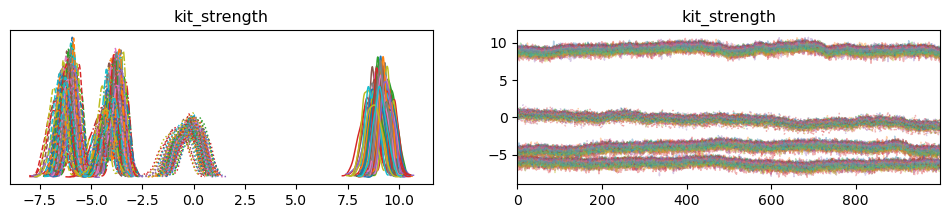

In [30]:
az.plot_trace(kit_only_trace, var_names=["kit_strength"])

In [ ]:
with kit_only_model(mar_apr_battle_records) as mar_apr_model:
    mar_apr_kit_only_trace = pm.sample(
        1000, tune=1000, cores=4, progressbar=True, nuts_sampler="nutpie"
    )

In [ ]:
import pickle

pickle.dump(
    mar_apr_kit_only_trace,
    open("2024-03-25-to-2024-04-26.kit_only_trace.pkl", "wb"),
)

In [16]:
az.summary(mar_apr_kit_only_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
weapon_strength[52gal],0.088,0.003,0.082,0.093,0.000,0.000,4435.0,2967.0,1.0
weapon_strength[52gal_deco],0.105,0.004,0.097,0.112,0.000,0.000,5529.0,2925.0,1.0
weapon_strength[96gal],0.078,0.012,0.054,0.099,0.000,0.000,5270.0,2559.0,1.0
weapon_strength[96gal_deco],0.107,0.007,0.094,0.121,0.000,0.000,5029.0,2716.0,1.0
weapon_strength[bamboo14mk1],0.070,0.010,0.052,0.088,0.000,0.000,4988.0,2676.0,1.0
...,...,...,...,...,...,...,...,...,...
weapon_strength_log__[115],-2.719,0.076,-2.858,-2.581,0.001,0.001,5708.0,3032.0,1.0
weapon_strength_log__[116],-2.501,0.093,-2.671,-2.326,0.001,0.001,5021.0,2875.0,1.0
weapon_strength_log__[117],-2.445,0.040,-2.522,-2.374,0.001,0.000,5551.0,2936.0,1.0
weapon_strength_log__[118],-2.908,0.215,-3.306,-2.518,0.003,0.002,5182.0,2717.0,1.0


array([[<Axes: title={'center': 'weapon_strength'}>,
        <Axes: title={'center': 'weapon_strength'}>],
       [<Axes: title={'center': 'weapon_strength_log__'}>,
        <Axes: title={'center': 'weapon_strength_log__'}>]], dtype=object)

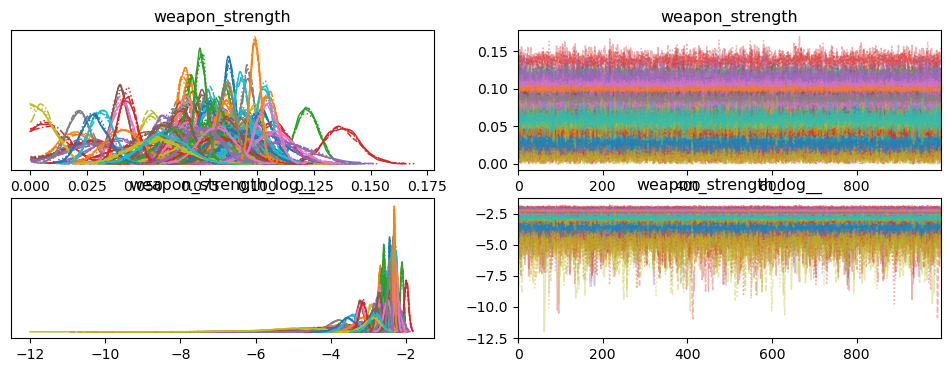

In [17]:
az.plot_trace(mar_apr_kit_only_trace)

In [20]:
az.summary(mar_apr_kit_only_trace, var_names=["kit_strength"], fmt="long")

,weapons,weapon_strength
mean,52gal,0.088
mean,52gal_deco,0.105
mean,96gal,0.078
mean,96gal_deco,0.107
mean,bamboo14mk1,0.070
...,...,...
r_hat,variableroller,1.001
r_hat,variableroller_foil,1.001
r_hat,wakaba,1.000
r_hat,wideroller,1.001
